# Predict Crew  Size

### Instructions
This coding exercise should be performed in python (which is the programming language used by the team). You are free to use the internet and any other libraries. Please save your work in a Jupyter notebook and email it to us for review.

Data file: cruise_ship_info.csv (this file will be emailed to you)

Objective: Build a regressor that recommends the “crew” size for potential ship buyers.

Please do the following steps (hint: use numpy, scipy, pandas, sklearn and matplotlib)
1. Read the file and display columns.
2. Calculate basic statistics of the data (count, mean, std, etc) and examine data and state your observations.
3. Select columns that will be probably important to predict “crew” size.
4. If you removed columns explain why you removed those.
5. Use one-hot encoding for categorical features.
6. Create training and testing sets (use 60% of the data for the training and reminder for testing).
7. Build a machine learning model to predict the ‘crew’ size.
8. Calculate the Pearson correlation coefficient for the training set and testing data sets.
9. Describe hyper-parameters in your model and how you would change them to improve the performance of the model.
10.What is regularization? What is the regularization parameter in your model?
11.Plot regularization parameter value vs Pearson correlation for the test and training sets, and see whether your model has bias problem or variance problem.

### Download data from github

In [381]:
! curl -O 'https://raw.githubusercontent.com/bot13956/ML_Model_for_Predicting_Ships_Crew_Size/master/cruise_ship_info.csv'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8734  100  8734    0     0  20358      0 --:--:-- --:--:-- --:--:-- 20358


### Download libraries

In [382]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

### 1. Read the file and display columns.

In [383]:
df = pd.read_csv('cruise_ship_info.csv')

In [384]:
df.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


### 2. Calculate basic statistics of the data (count, mean, std, etc) and examine data and state your observations.

In [385]:
df.describe()

,Age,Tonnage,passengers,length,cabins,passenger_density,crew
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,15.689873,71.284671,18.457405,8.130633,8.830000,39.900949,7.794177
std,7.615691,37.229540,9.677095,1.793474,4.471417,8.639217,3.503487
min,4.000000,2.329000,0.660000,2.790000,0.330000,17.700000,0.590000
25%,10.000000,46.013000,12.535000,7.100000,6.132500,34.570000,5.480000
50%,14.000000,71.899000,19.500000,8.555000,9.570000,39.085000,8.150000
75%,20.000000,90.772500,24.845000,9.510000,10.885000,44.185000,9.990000
max,48.000000,220.000000,54.000000,11.820000,27.000000,71.430000,21.000000


In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ship_name          158 non-null    object 
 1   Cruise_line        158 non-null    object 
 2   Age                158 non-null    int64  
 3   Tonnage            158 non-null    float64
 4   passengers         158 non-null    float64
 5   length             158 non-null    float64
 6   cabins             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   crew               158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


We have 158 datapoints. 

Some values as passengers and cabins are float, this values are not clear for me. 


I can see that some ships have only different names, the rest is equal.


Passenger_density might be highly correlated to cabins/passengers

### Check for nan values

<AxesSubplot:>

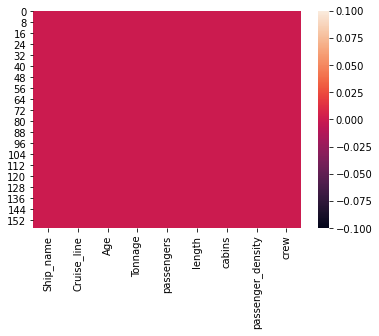

In [387]:
sns.heatmap(df.isna())

Data is clean and has no Nan values

### 3.Select columns that will be probably important to predict “crew” size.

### Check correlated features

<AxesSubplot:>

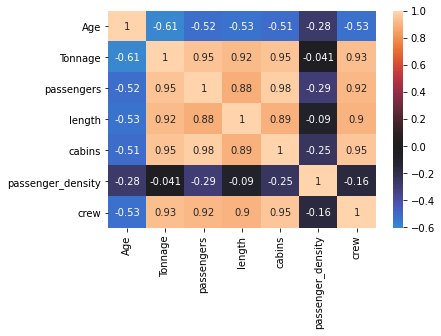

In [388]:
sns.heatmap(df.corr(), center = 0, annot=True)

To do so I will use scatter plots to see gow our dependent variable depends on each feauture

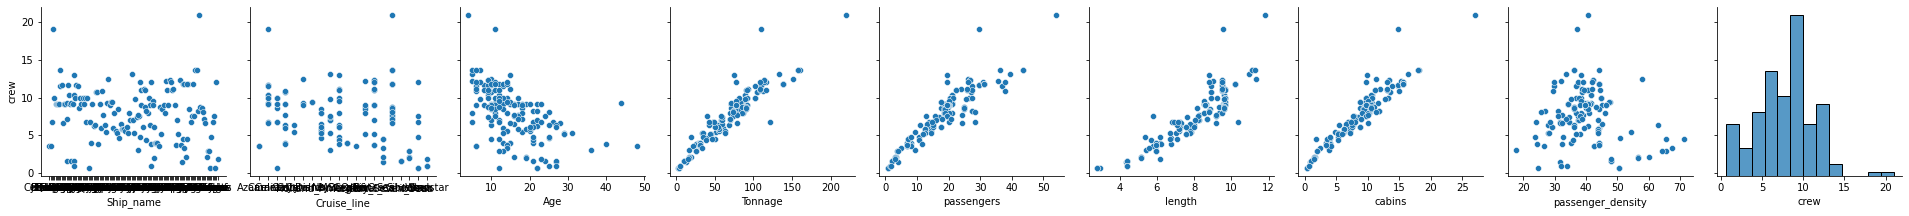

In [389]:
# plt.pyplot.figure(figsize = (25,25))
sns.pairplot(df, y_vars = ['crew'], x_vars = df[::-1], height = 3.0) 

### 4. If you removed columns explain why you removed those.

Passenger_density has tiny correlation with crew size and not linear dependences, i will drop it to avoid overfitting our model and reduce features

In [390]:
df = df.drop('passenger_density', axis = 1)

I will remove column Ship_name as it is not informative and remove duplicates from dataset


In [391]:
df = df.drop('Ship_name', axis = 1)
df = df.drop_duplicates()
len(df)

153

There are 2 outlayers where crew is larger than 15 ppl, after i check base model i will remove them
The crew variable has linear dependecies from main features Tonnage, passengers, length and cabins 

### 5. Use one-hot encoding for categorical features.

In [392]:
df.Cruise_line.unique(), len(df.Cruise_line.unique())

(array(['Azamara', 'Carnival', 'Celebrity', 'Costa', 'Crystal', 'Cunard',
        'Disney', 'Holland_American', 'MSC', 'Norwegian', 'Oceania',
        'Orient', 'P&O', 'Princess', 'Regent_Seven_Seas',
        'Royal_Caribbean', 'Seabourn', 'Silversea', 'Star', 'Windstar'],
       dtype=object),
 20)

We have 20 cruise line names, i will one hot encode them

In [393]:
df[df.Cruise_line.unique()] = pd.get_dummies(df['Cruise_line'])
df = df.drop('Cruise_line', axis = 1)
df.head()

,Age,Tonnage,passengers,length,cabins,crew,Azamara,Carnival,Celebrity,Costa,...,Oceania,Orient,P&O,Princess,Regent_Seven_Seas,Royal_Caribbean,Seabourn,Silversea,Star,Windstar
0,6,30.277,6.94,5.94,3.55,3.55,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,47.262,14.86,7.22,7.43,6.70,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,110.000,29.74,9.53,14.88,19.10,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,101.353,26.42,8.92,13.21,10.00,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,22,70.367,20.52,8.55,10.20,9.20,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Create training and testing sets (use 60% of the data for the training and reminder for testing).

In [394]:
X = df.drop('crew', axis = 1)
y = df.crew

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

### 7. Build a machine learning model to predict the ‘crew’ size.

In [ ]:
#Helper function to make predition, print accuracy scores and save model in df
models = pd.DataFrame(columns = ['model', 'test_R2', 'train_R2', 'test_MSE', 'train_MSE'])

In [396]:
def make_pred(model, model_name, X_test, X_train, y_test = y_test, y_train = y_train):
    global models
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Model name: ', model_name)
    print("test r2 score :", r2_score(y_test, y_pred_test))
    print("train r2 score  :", r2_score(y_train, y_pred_train))
    print("MSE test: ", mean_squared_error(y_test, y_pred_test))
    print("MSE train: ", mean_squared_error(y_train, y_pred_train))
    models.loc[len(models)] = [model_name, r2_score(y_test, y_pred_test), r2_score(y_train, y_pred_train), 
                   mean_squared_error(y_test, y_pred_test), mean_squared_error(y_train, y_pred_train)]
    return y_pred_test, y_pred_train

In [397]:
models

,model,test_R2,train_R2,test_MSE,train_MSE


In [398]:
lr = LinearRegression()

In [399]:
lr.fit(X_train, y_train)

LinearRegression()

In [400]:
make_pred(lr, 'base_linear_regression', X_test, X_train)

Model name:  base_linear_regression
test r2 score : 0.9566862731118811
train r2 score  : 0.9325490516483538
MSE test:  0.42146809563521775
MSE train:  0.9236828590441323


(array([ 4.04208105,  4.32039671, 11.52474046,  8.18876402, -0.18546925,
        12.35097455,  9.87598606,  4.33559779, 10.18474694, 10.16984565,
        11.3626887 ,  9.29894433, 12.78458739,  5.8853805 ,  5.31305169,
         3.27964297,  0.7367823 , 12.3930556 ,  7.12932805,  9.30901876,
        10.48703482,  7.17781496,  3.33770218,  4.94359073,  5.76540873,
         6.39222509,  9.04094692,  7.59375021,  7.57270969, 10.82788238,
         2.44196334,  9.41829979,  7.2904808 ,  8.36717594, 10.74031567,
         4.52820583,  9.31998485,  6.87024177,  8.1677235 , 12.32993403,
         9.82249956, 13.59897928,  2.77977059,  8.56182409,  9.40414694,
         9.39340933,  3.05006207,  8.38873893,  5.91696592, 11.03663863,
         2.51336509,  6.8766195 ,  5.29785508,  0.59133222,  1.66955213,
         6.57919136, 11.14059957,  9.39725926,  4.12692927,  9.05321626,
         3.18061066,  9.22333919]),
 array([ 0.92428847,  7.09812244, 11.15171758, 12.80877475,  9.80145904,
         9.7804

We have problem: model has negative predictions

In [401]:
df.columns

Index(['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'crew', 'Azamara',
       'Carnival', 'Celebrity', 'Costa', 'Crystal', 'Cunard', 'Disney',
       'Holland_American', 'MSC', 'Norwegian', 'Oceania', 'Orient', 'P&O',
       'Princess', 'Regent_Seven_Seas', 'Royal_Caribbean', 'Seabourn',
       'Silversea', 'Star', 'Windstar'],
      dtype='object')

In [402]:
models

,model,test_R2,train_R2,test_MSE,train_MSE
0,base_linear_regression,0.956686,0.932549,0.421468,0.923683


I will remove outlayers and check again

In [403]:
df = df.loc[df.crew<15]

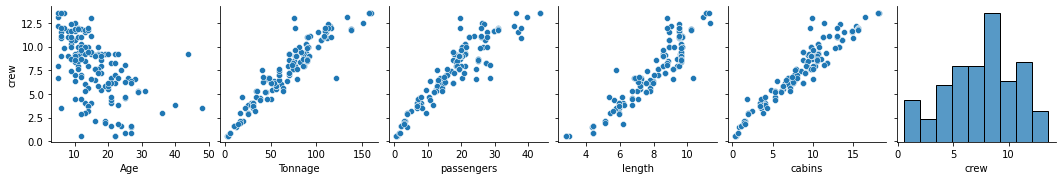

In [404]:
sns.pairplot(df[['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'crew']], y_vars = ['crew']) 

In [405]:
X = df.drop('crew', axis = 1)
y = df.crew
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [407]:
lr_2 = LinearRegression()
lr_2.fit(X_train, y_train)

make_pred(lr_2, 'linear_regression_no_outlayers', X_test, X_train, y_test, y_train)

Model name:  linear_regression_no_outlayers
test r2 score : 0.9182537853068535
train r2 score  : 0.9668060533012272
MSE test:  0.8268695391048306
MSE train:  0.3182662578535533


(array([ 9.49606533, 10.86718296,  7.89051233,  9.54088769,  6.15146927,
         9.19694379,  6.91354787,  7.03274946,  5.40421848,  3.41618029,
        10.73388586,  9.99345475,  3.59223136,  6.40919304, 12.11191751,
         1.6       ,  8.64330439,  3.15896563,  5.3818073 ,  7.90179819,
         6.58651799,  4.04482236, 10.04747686,  7.13546477,  8.21529113,
         3.16372802,  2.37512587,  7.11769025, 10.88015678,  3.77321219,
        10.09229922, 10.47713706, 11.97612858,  8.87862498, 11.95371741,
         4.59738358, 10.35579987,  9.55040728, 10.96048986,  8.92344733,
         5.6588276 ,  5.53984109,  8.96260982,  0.59567858,  8.81139145,
         8.8562138 ,  4.74837375,  8.20205174,  5.37550785, 11.93130623,
         4.4119573 ,  2.88537232,  1.28011326,  3.74268277,  4.31172103,
         6.30020334,  7.0866395 ,  1.57023861,  7.93348091, 12.88902043,
         2.75727971]),
 array([11.88648387,  9.45889649, 10.06988804,  9.12209553,  9.09705831,
        11.935637  , 11.3092

### 8. Calculate the Pearson correlation coefficient for the training set and testing data sets.
The Pearson’s correlation coefficient is calculated as the covariance of the two variables divided by the product of the standard deviation of each data sample. It is the normalization of the covariance between the two variables to give an interpretable score.

In [408]:
X_train.columns

Index(['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'Azamara',
       'Carnival', 'Celebrity', 'Costa', 'Crystal', 'Cunard', 'Disney',
       'Holland_American', 'MSC', 'Norwegian', 'Oceania', 'Orient', 'P&O',
       'Princess', 'Regent_Seven_Seas', 'Royal_Caribbean', 'Seabourn',
       'Silversea', 'Star', 'Windstar'],
      dtype='object')

In [409]:
from scipy.stats import pearsonr
def pearson_coeff(X, y):
    for c in X.columns:
        corr, _ = pearsonr(X[c], y)
        print('Feature:',c,', Pearsons correlation: %.3f' % corr)

In [410]:
print('TRAIN DATA')
pearson_coeff(X_train, y_train)
print('TEST DATA')
pearson_coeff(X_test, y_test)

TRAIN DATA
Feature: Age , Pearsons correlation: -0.574
Feature: Tonnage , Pearsons correlation: 0.933
Feature: passengers , Pearsons correlation: 0.907
Feature: length , Pearsons correlation: 0.903
Feature: cabins , Pearsons correlation: 0.950
Feature: Azamara , Pearsons correlation: nan
Feature: Carnival , Pearsons correlation: 0.225
Feature: Celebrity , Pearsons correlation: 0.067
Feature: Costa , Pearsons correlation: 0.064
Feature: Crystal , Pearsons correlation: -0.064
Feature: Cunard , Pearsons correlation: 0.033
Feature: Disney , Pearsons correlation: 0.059
Feature: Holland_American , Pearsons correlation: -0.202
Feature: MSC , Pearsons correlation: 0.089
Feature: Norwegian , Pearsons correlation: 0.061
Feature: Oceania , Pearsons correlation: -0.145
Feature: Orient , Pearsons correlation: nan
Feature: P&O , Pearsons correlation: 0.031
Feature: Princess , Pearsons correlation: 0.078
Feature: Regent_Seven_Seas , Pearsons correlation: -0.171
Feature: Royal_Caribbean , Pearsons cor

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Cruise company name has very small correlation with crew size

### Scale data
Our variables are on different scales, for example the Age variable ranges from about 16 years to 48 years, while the Tonnage variable ranges from 2 to 220. It is therefore important that when a regression model is built using these variables, variables be brought to same scale either by standardizing or normalizing the data.

In [411]:
from sklearn.preprocessing import StandardScaler

In [412]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['Age', 'Tonnage', 'passengers', 'length', 'cabins']])
X_test_scaled = scaler.transform(X_test[['Age', 'Tonnage', 'passengers', 'length', 'cabins']])

In [413]:
X_train_scaled

array([[-1.76555337e-01,  1.86093091e+00,  1.22733959e+00,
         1.15001181e+00,  1.49988068e+00],
       [-5.77143077e-01,  4.73074641e-01,  9.61362601e-03,
         7.87463520e-01,  1.14752347e-01],
       [-4.43613831e-01,  4.54309716e-01,  7.15681047e-02,
         7.93937597e-01,  8.55917506e-02],
       [ 9.05031561e-02,  5.66549109e-02, -8.86589954e-02,
         1.53004011e-01, -1.16102375e-02],
       [ 2.24032403e-01,  5.66549109e-02, -8.01135501e-02,
         1.53004011e-01, -1.16102375e-02],
       [-1.24478931e+00,  1.11272815e+00,  1.94088427e+00,
         7.03300524e-01,  1.49988068e+00],
       [-1.24478931e+00,  1.08280004e+00,  1.96011152e+00,
         7.03300524e-01,  1.36136784e+00],
       [-1.76555337e-01,  2.93305460e-02, -5.34090334e-03,
         2.37167007e-01,  6.61513530e-02],
       [-1.37831856e+00,  2.51934935e+00,  1.78279353e+00,
         1.74562686e+00,  2.13169360e+00],
       [-1.76555337e-01,  2.14884832e-01, -2.29658844e-01,
         7.87463520e-01

In [414]:
lr_s = LinearRegression()
lr_s.fit(X_train_scaled, y_train)

make_pred(lr_s, 'linear_regression_scaled_data', X_test_scaled, X_train_scaled, y_test, y_train)

Model name:  linear_regression_scaled_data
test r2 score : 0.9376323322326404
train r2 score  : 0.9279215247684087
MSE test:  0.6308539777091771
MSE train:  0.6910942766741454


(array([ 8.8145396 , 10.60573415,  7.6310276 ,  8.85997162,  3.79808407,
         9.65251253,  6.59709855,  7.41744922,  5.89831515,  3.56693524,
         9.71885554,  9.76700358,  4.05692276,  6.42464422, 12.15765361,
         1.44292935,  9.06067744,  0.23897131,  5.87559914,  8.47808439,
         6.09242285,  3.80315579,  9.01251573,  7.88516953,  9.3594239 ,
         0.24441663,  2.27276117,  7.68806762, 10.69352308,  4.20588036,
         9.05794775, 10.63434209, 12.63723832,  8.93320965, 12.61452231,
         5.66269532, 11.14493509,  5.39722376, 10.95005609,  8.97864167,
         5.99300819,  5.37570342,  6.84428125,  1.20996386,  8.86506162,
         8.91049364,  4.32239331,  9.35505815,  4.55753592, 12.59180629,
         4.67298568,  2.95679683,  0.90943068,  2.62126932,  4.06696557,
         6.81382813,  7.55366941,  0.63937734,  8.3992091 ,  9.93411819,
         3.12768126]),
 array([12.54637427,  9.23969548,  9.03523174,  8.40139696,  8.36709777,
        11.65976414, 11.1217

We can see, that our model performes much better on scaled data, no sign of overfitting.

### Add polinomial features 
I want to check if our model will perform better with polinomial features

In [415]:
from sklearn.preprocessing import PolynomialFeatures

In [416]:
pf = PolynomialFeatures(degree = 2)
X_train_poly = pf.fit_transform(X_train_scaled)
X_test_poly = pf.transform(X_test_scaled)

In [417]:
X_test_poly

array([[ 1.00000000e+00, -1.76555337e-01,  3.84286916e-02, ...,
         4.73908532e-03,  1.02416872e-02,  2.21334183e-02],
       [ 1.00000000e+00, -1.76555337e-01,  7.68824230e-01, ...,
         1.07455515e-01,  3.03674077e-01,  8.58196482e-01],
       [ 1.00000000e+00,  6.24620143e-01, -7.49997453e-01, ...,
         3.27289910e-01,  9.14451469e-02,  2.55498707e-02],
       ...,
       [ 1.00000000e+00,  2.24032403e-01, -1.95719867e-02, ...,
         8.65102768e-03, -5.47473360e-03,  3.46464132e-03],
       [ 1.00000000e+00, -7.10672324e-01,  2.26196759e+00, ...,
         3.51603149e+00,  8.84994259e-01,  2.22755354e-01],
       [ 1.00000000e+00,  2.76108809e+00, -1.76479983e+00, ...,
         3.80667763e+00,  2.63979438e+00,  1.83060270e+00]])

In [418]:
lr_p = LinearRegression()
lr_p.fit(X_train_poly, y_train)

LinearRegression()

In [419]:
make_pred(lr_p, 'linear_regression_scaled_data_2_poly', X_test_poly, X_train_poly, y_test, y_train)

Model name:  linear_regression_scaled_data_2_poly
test r2 score : 0.9276283104857755
train r2 score  : 0.9417713599440939
MSE test:  0.7320454626247279
MSE train:  0.5583009317533147


(array([ 9.1116777 , 10.66587739,  7.57850686,  9.16172889,  4.55156249,
         9.69973438,  6.38562267,  6.68198417,  6.10936964,  2.58016956,
         9.85293193,  9.66429197,  3.73609856,  6.15997645, 12.36422298,
         1.59147959,  8.64168063,  0.17265968,  6.09197424,  7.75458952,
         6.35485213,  3.91306228,  9.67524448,  7.46615099,  8.84610117,
         0.18926222,  2.30559573,  8.179317  , 11.12051724,  4.18825252,
         9.51519864, 10.90345781, 11.85232964,  8.86399681, 11.81432276,
         4.86164489, 11.09059715,  6.13129938, 11.30094649,  8.92744325,
         6.17043466,  5.11379308,  7.10665644,  1.30249193,  8.77121432,
         8.83275103,  3.98347506,  8.85796741,  4.87560687, 11.77663417,
         4.50229398,  2.32205355,  0.95009893,  1.16724988,  4.38655044,
         6.97452019,  6.92732692,  2.45218006,  8.71516312, 15.14738628,
         3.08056269]),
 array([11.70221184,  9.86311789,  9.59506241,  8.76738001,  8.75926832,
        11.95785857, 11.2506

We can see that model performes worse, we can see sign of overfitting again. 

### Regularization to prevent over-fitting

We have trained the model on unscaled data with all features, and got good scores while using training data. But during the process of prediction, we found that the model is underperforming when compared to the training part. Now, this may be a case of over-fitting which is causing incorrect prediction by the model. Regularizing the model, in this case, can help resolve the problem.


The two types of regularization are
- L1 regularization or LASSO regression
- L2 regularization or Ridge regression


In [420]:
def ridge_reg(a, X_train, X_test, y_train = y_train, y_test = y_test):
    ridge = Ridge(alpha = a)
    ridge.fit(X_train, y_train)
    y_pred_test, y_pred_train = make_pred(ridge, f'ridge_alpha_{a}', X_test, X_train, y_test, y_train)
    

In [421]:
X_train

,Age,Tonnage,passengers,length,cabins,Azamara,Carnival,Celebrity,Costa,Crystal,...,Oceania,Orient,P&O,Princess,Regent_Seven_Seas,Royal_Caribbean,Seabourn,Silversea,Star,Windstar
141,14,138.000,31.14,10.20,15.57,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
98,11,91.627,19.74,9.64,9.87,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
27,12,91.000,20.32,9.65,9.75,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
28,16,77.713,18.82,8.66,9.35,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
26,17,77.713,18.90,8.66,9.35,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,11,90.000,22.40,9.65,11.20,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,18,77.499,19.50,8.56,9.75,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
16,9,88.500,21.24,9.63,10.62,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,9,116.000,26.00,9.51,13.00,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [341]:
ridge_reg(0, X_train, X_test)

Model name:  ridge_alpha_0
test r2 score : 0.9182537853068534
train r2 score  : 0.966806053301227
MSE test:  0.826869539104832
MSE train:  0.3182662578535535


In [422]:
for a in np.arange(0.,10.,0.1):
    ridge_reg(a, X_train, X_test)

Model name:  ridge_alpha_0.0
test r2 score : 0.9182537853068534
train r2 score  : 0.966806053301227
MSE test:  0.826869539104832
MSE train:  0.3182662578535535
Model name:  ridge_alpha_0.1
test r2 score : 0.9270617242652859
train r2 score  : 0.9667316108476137
MSE test:  0.7377765278337783
MSE train:  0.31898001814701826
Model name:  ridge_alpha_0.2
test r2 score : 0.9331203556728003
train r2 score  : 0.9665632267973064
MSE test:  0.6764929836557068
MSE train:  0.32059449810204854
Model name:  ridge_alpha_0.30000000000000004
test r2 score : 0.9376425690073436
train r2 score  : 0.9663418140152484
MSE test:  0.6307504319093807
MSE train:  0.3227174218455265
Model name:  ridge_alpha_0.4
test r2 score : 0.9411877124082992
train r2 score  : 0.9660862566293141
MSE test:  0.5948910211585312
MSE train:  0.32516772682511247
Model name:  ridge_alpha_0.5
test r2 score : 0.9440575613510714
train r2 score  : 0.9658075466769883
MSE test:  0.5658622681879116
MSE train:  0.3278400204923362
Model name:

test r2 score : 0.9641923559424544
train r2 score  : 0.9535957121874319
MSE test:  0.36219720080537104
MSE train:  0.44492808175206494
Model name:  ridge_alpha_5.5
test r2 score : 0.9642126222022429
train r2 score  : 0.9534204804342792
MSE test:  0.361992205956942
MSE train:  0.44660821803833173
Model name:  ridge_alpha_5.6000000000000005
test r2 score : 0.9642306922309201
train r2 score  : 0.9532472173186641
MSE test:  0.36180942616291767
MSE train:  0.44826947886794244
Model name:  ridge_alpha_5.7
test r2 score : 0.9642466866567496
train r2 score  : 0.953075873816532
MSE test:  0.36164764125870413
MSE train:  0.4499123342875154
Model name:  ridge_alpha_5.800000000000001
test r2 score : 0.9642607174895331
train r2 score  : 0.9529064025241104
MSE test:  0.3615057182561464
MSE train:  0.4515372388082742
Model name:  ridge_alpha_5.9
test r2 score : 0.9642728888313481
train r2 score  : 0.9527387576004729
MSE test:  0.36138260415435436
MSE train:  0.45314463195674237
Model name:  ridge_alp

In [423]:
models

,model,test_R2,train_R2,test_MSE,train_MSE
0,base_linear_regression,0.956686,0.932549,0.421468,0.923683
1,linear_regression_no_outlayers,0.918254,0.966806,0.826870,0.318266
2,linear_regression_scaled_data,0.937632,0.927922,0.630854,0.691094
3,linear_regression_scaled_data_2_poly,0.927628,0.941771,0.732045,0.558301
4,ridge_alpha_0.0,0.918254,0.966806,0.826870,0.318266
...,...,...,...,...,...
99,ridge_alpha_9.5,0.963974,0.947631,0.364408,0.502120
100,ridge_alpha_9.600000000000001,0.963953,0.947509,0.364620,0.503290
101,ridge_alpha_9.700000000000001,0.963932,0.947387,0.364836,0.504453
102,ridge_alpha_9.8,0.963910,0.947267,0.365056,0.505608


<AxesSubplot:>

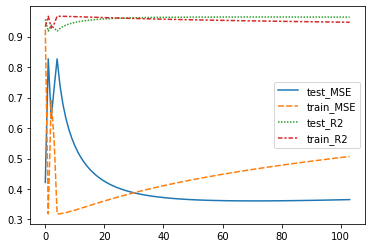

In [434]:
sns.lineplot(data = models[['test_MSE', 'train_MSE', 'test_R2', 'train_R2']])

In [435]:
models.iloc[28:34]

,model,test_R2,train_R2,test_MSE,train_MSE
28,ridge_alpha_2.4000000000000004,0.961180,0.960091,0.392665,0.382653
29,ridge_alpha_2.5,0.961440,0.959824,0.390033,0.385210
30,ridge_alpha_2.6,0.961679,0.959562,0.387619,0.387726
31,ridge_alpha_2.7,0.961898,0.959303,0.385404,0.390201
32,ridge_alpha_2.8000000000000003,0.962099,0.959049,0.383369,0.392638
33,ridge_alpha_2.9000000000000004,0.962284,0.958799,0.381496,0.395036


We can see the best results with alpha = 2.6 

### 9. Describe hyper-parameters in your model and how you would change them to improve the performance of the model.

In Ridge megression model our Hyperparameter is alpha
We checked the best value

### 10. What is regularization? What is the regularization parameter in your model?
Its adding small bias(alpha) to our cost function

### 11. Plot regularization parameter value vs Pearson correlation for the test and training sets, and see whether your model has bias problem or variance problem.

What is bias?
Bias is the difference between the average prediction of our model and the correct value which we are trying to predict. Model with high bias pays very little attention to the training data and oversimplifies the model. It always leads to high error on training and test data.

What is variance?
Variance is the variability of model prediction for a given data point or a value which tells us spread of our data. Modael with high variance pays a lot of attention to training data and does not generalize on data it neve seen before. As a result, such models perform very well on training data but has high error rates on test data.


In [ ]:
intercept = clf.intercept_
    coefficient = clf.coef_
    parameters = coefficient + intercept

In [442]:
ridge = Ridge(alpha = 2.6)
ridge.fit(X_train, y_train)

Ridge(alpha=2.6)

In [443]:
intercept = ridge.intercept_
coefficient = ridge.coef_
parameters = coefficient + intercept

In [444]:
intercept, coefficient, parameters

(-0.8154564488252909,
 array([-0.01329459,  0.01116611, -0.06771853,  0.48681798,  0.61444964,
         0.        ,  0.09804062,  0.37633324, -0.34328408,  0.0153145 ,
         0.14240274,  0.28055161, -0.53966883, -0.1344829 ,  0.51609526,
         0.04079925,  0.        , -0.06358291, -0.09246401, -0.00740619,
        -0.82382048, -0.00752461, -0.15378369,  1.02662427, -0.33014379]),
 array([-0.82875104, -0.80429034, -0.88317498, -0.32863847, -0.20100681,
        -0.81545645, -0.71741583, -0.43912321, -1.15874053, -0.80014195,
        -0.67305371, -0.53490483, -1.35512528, -0.94993935, -0.29936119,
        -0.7746572 , -0.81545645, -0.87903935, -0.90792046, -0.82286264,
        -1.63927693, -0.82298105, -0.96924014,  0.21116782, -1.14560024]))

In [447]:
len(parameters)

25

In [458]:
def pearson_coeff_param(X, y, parameters = parameters):
    for c,p in zip(X.columns, parameters):
        corr, _ = pearsonr(X[c], y)
        print('Feature:',c, f', Pearsons correlation: {corr}, Parameter: {p}')

In [459]:
print('TRAIN DATA')
pearson_coeff_param(X_train, y_train)

TRAIN DATA
Feature: Age , Pearsons correlation: -0.5741724290219018, Parameter: -0.828751040772485
Feature: Tonnage , Pearsons correlation: 0.9333597087663635, Parameter: -0.8042903421835131
Feature: passengers , Pearsons correlation: 0.9074237482448468, Parameter: -0.8831749762658336
Feature: length , Pearsons correlation: 0.9032446523694527, Parameter: -0.3286384727895403
Feature: cabins , Pearsons correlation: 0.9503972393994883, Parameter: -0.20100681040669666
Feature: Azamara , Pearsons correlation: nan, Parameter: -0.8154564488252909
Feature: Carnival , Pearsons correlation: 0.22493299418990673, Parameter: -0.7174158268618399
Feature: Celebrity , Pearsons correlation: 0.06651093050764867, Parameter: -0.43912321126199616
Feature: Costa , Pearsons correlation: 0.06365015090314735, Parameter: -1.1587405313102392
Feature: Crystal , Pearsons correlation: -0.06410233585763404, Parameter: -0.8001419513170935
Feature: Cunard , Pearsons correlation: 0.03346040755590145, Parameter: -0.6730